# Fiddling with CII 1334 stacks from QPQ9 NIR 

In [1]:
%matplotlib inline

In [2]:
# imports
from __future__ import print_function,absolute_import,division,unicode_literals
import numpy as np
import glob,os,sys,copy 
from scipy import stats as scistats
import matplotlib as mpl
mpl.rcParams['font.family']='stixgeneral'
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.table import QTable,Table
from astropy.io import ascii
from astropy import units as u
from astropy import constants as const
from linetools.spectralline import AbsLine
from xastropy.igm.abs_sys import abssys_utils as abssys
from xastropy import spec as xpsec
from xastropy.plotting import utils as xputils
from xastropy.xutils import xdebug as xdb
from xastropy.obs import radec as xor
from xastropy.atomic import ionization as xai
sys.path.append(os.path.abspath("../../../../py"))
from enigma.qpq import utils as qpqutils
from enigma.qpq import spec as qpqs
from enigma.qpq import stacks as qpqk
sys.path.append(os.path.abspath("../py"))
import qpq9_analy as qpq9a
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


## Load stack_tup

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
length of sample after and before culling 32 56
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
St

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:295: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


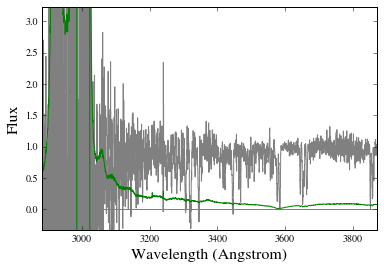

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xa

/Users/lwymarie/python/specdb/specdb/specdb.py:88: UserWarning: Found multiple sources.  Hope you expected that.
  warnings.warn("Found multiple sources.  Hope you expected that.")


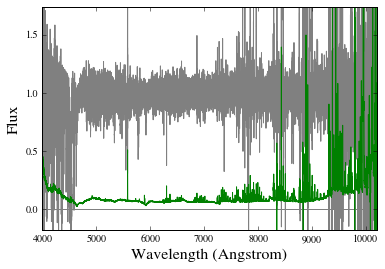

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:269: RuntimeWarning: invalid value encountered in greater
  gdsigval = np.where(self.data['sig'][kk].data > 0.)[0]
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:270: RuntimeWarning: invalid value encountered in less_equal
  badsigval = self.data['sig'][kk].data <= 0.


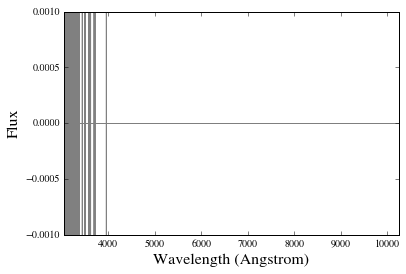

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:807: UserWarning: Ignoring NAN in flux
  warnings.warn("Ignoring NAN in flux")


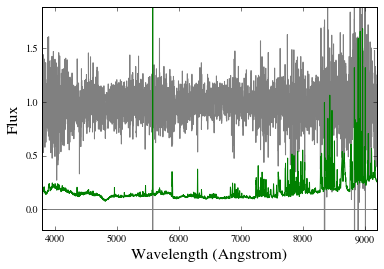

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

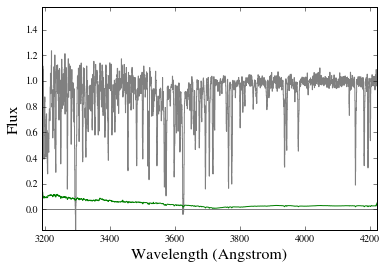

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xavi

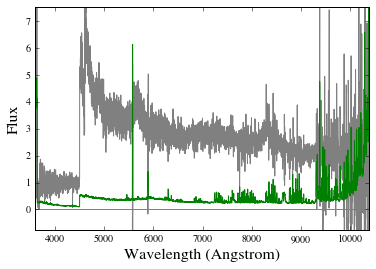

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

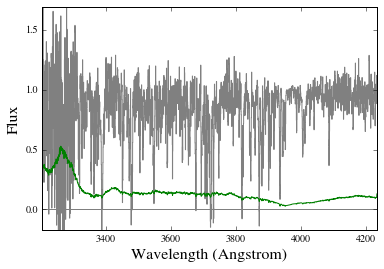

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

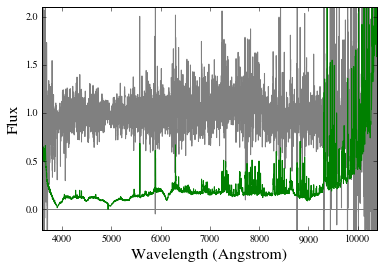

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

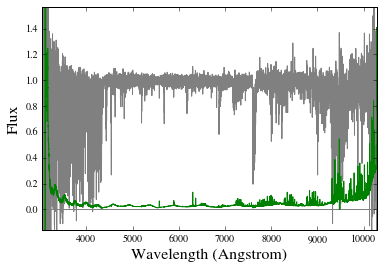

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPa

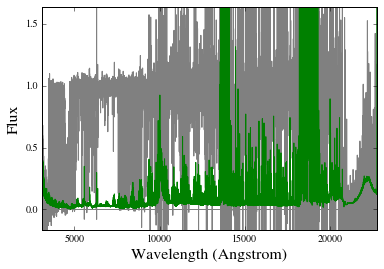

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

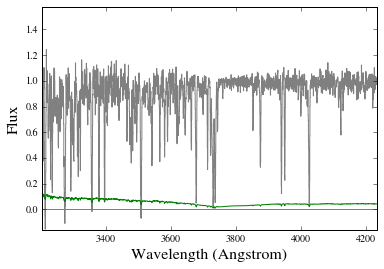

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

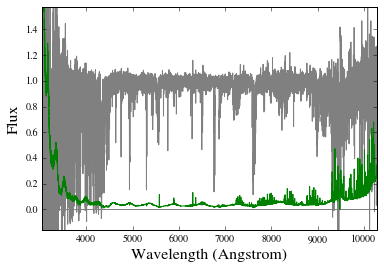

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

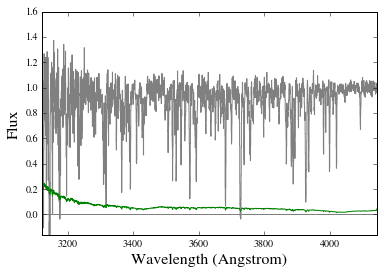

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in

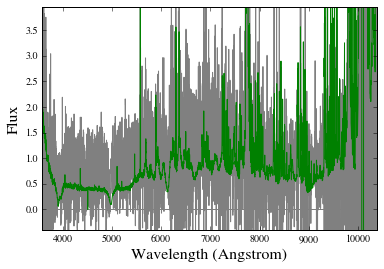

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

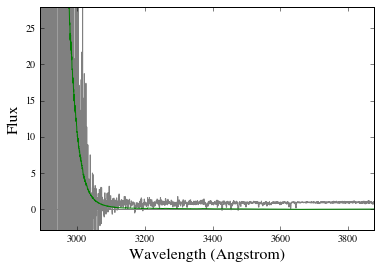

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

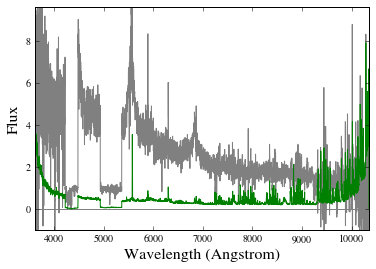

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

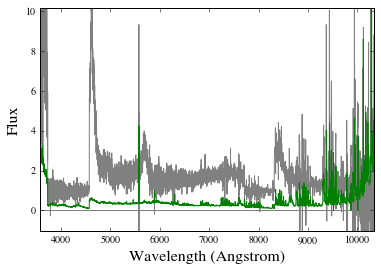

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHO

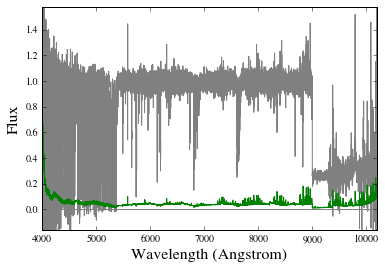

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/

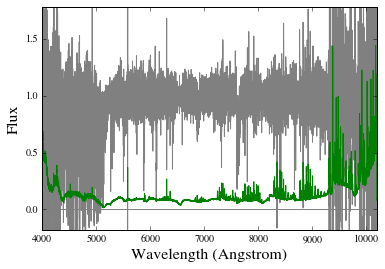

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: 

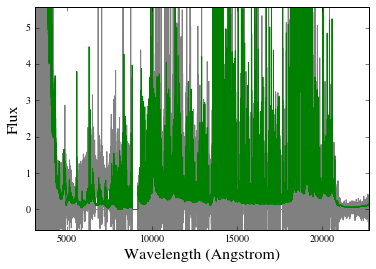

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/x

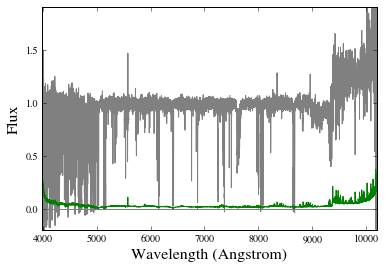

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

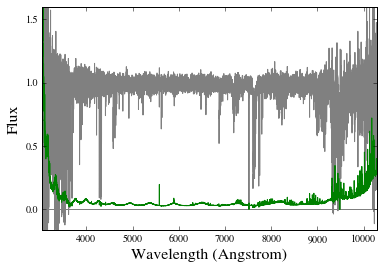

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continuu

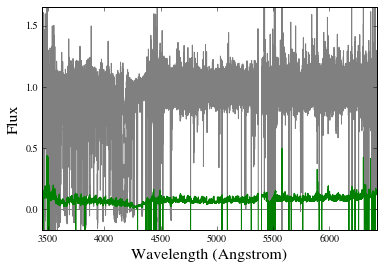

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

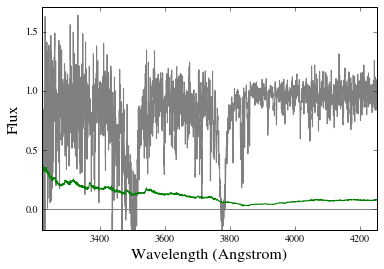

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

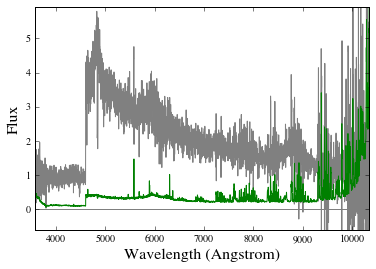

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

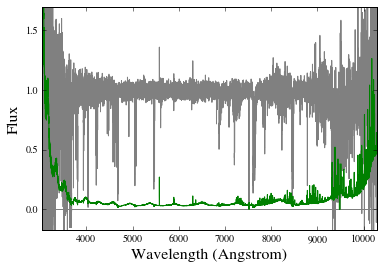

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continu

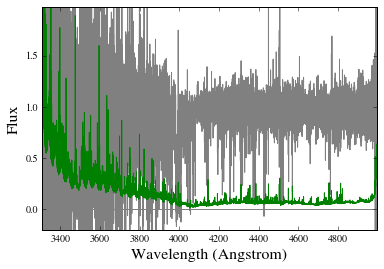

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 8 spectra totalling 0.0008 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

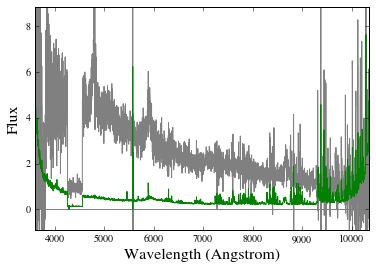

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

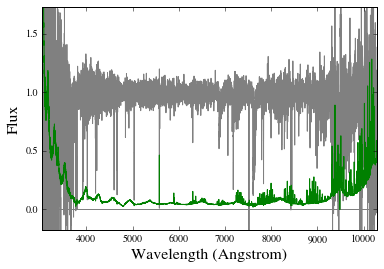

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

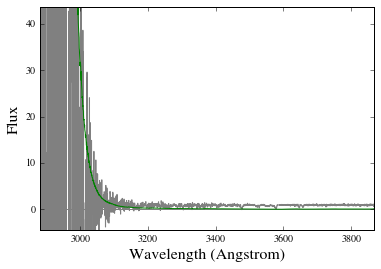

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

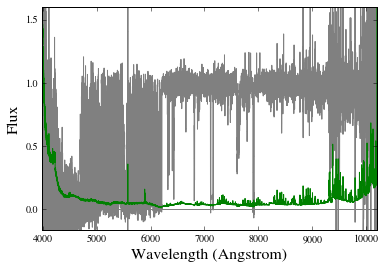

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 2 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

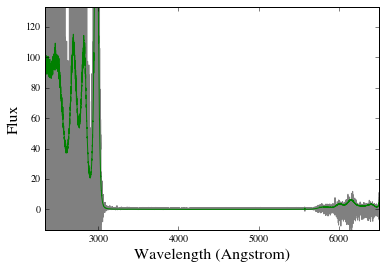

In [3]:
reload(qpqk)
reload(qpq9k)
stack_tup0 = qpq9k.qpq9_IRMgII(passback=True,wrest=1334.5323*u.AA)

## Stack and Plot

### All

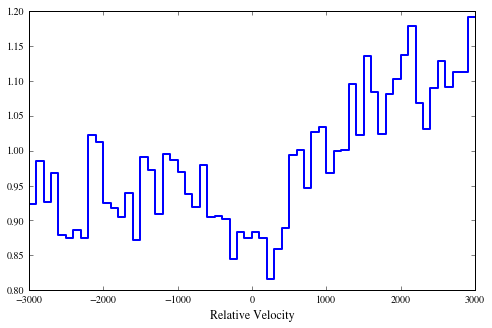

In [4]:
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stack_tup = (fin_velo, stck_img, stck_msk, all_dict)
#
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

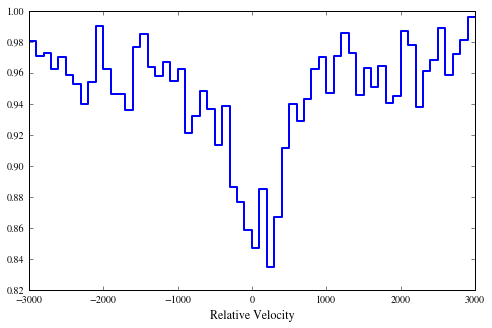

In [8]:
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)
idx_mask = [13,16,27]
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

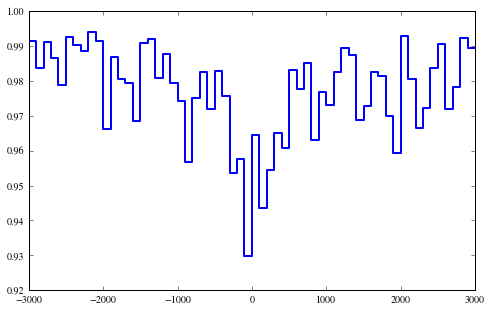

In [9]:
fin_flx_med = np.median(stck_img*stck_msk,0)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo,fin_flx_med,drawstyle='steps',linewidth=2.)

### Centroid 

In [10]:
tau = np.log(1./fin_flx)
print('tau weighted mean =',np.sum(fin_velo*tau)/np.sum(tau)) 
print('tau weighted RMS =',np.sqrt(np.sum((fin_velo**2)*tau)/np.sum(tau)))
print('tau weighted mean, within 2000 km/s=',np.sum(fin_velo[10:51]*tau[10:51])/np.sum(tau[10:51]))

tau weighted mean = -39.0545204615 km / s
tau weighted RMS = 1407.99759801 km / s
tau weighted mean, within 2000 km/s= 51.0651163067 km / s


### Mask DLA

In [8]:
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)

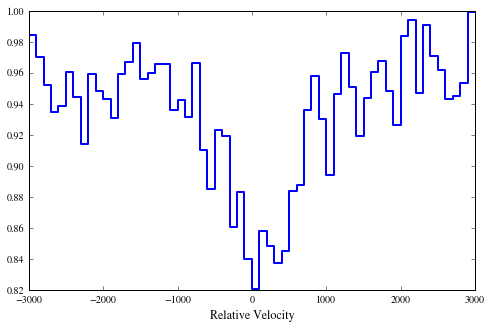

In [9]:
idx_mask = [19] #J1553, number 19 for wrest = 1334
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

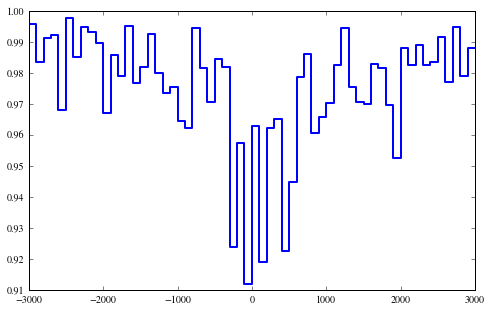

In [10]:
fin_flx_med = np.median(stck_img*stck_mskN,0)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo,fin_flx_med,drawstyle='steps',linewidth=2.)

In [11]:
tau = np.log(1./fin_flx)
print('tau weighted mean =',np.sum(fin_velo*tau)/np.sum(tau)) 
print('tau weighted RMS =',np.sqrt(np.sum((fin_velo**2)*tau)/np.sum(tau)))
print('tau weighted mean, within 2000 km/s=',np.sum(fin_velo[10:51]*tau[10:51])/np.sum(tau[10:51]))

tau weighted mean = -13.832968031 km / s
tau weighted RMS = 1421.81666862 km / s
tau weighted mean, within 2000 km/s= 105.892526726 km / s


### Mask noisy spectra

In [31]:
# Mask
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stck_mskN = copy.deepcopy(stck_msk)

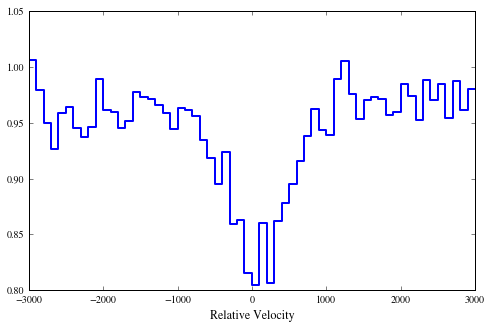

In [32]:
idx_mask = [8,18] #J1002, number 8 for wrest = 1334
for idx in idx_mask:
    stck_mskN[idx,:] = 0.
# Stack
stack_tup = (fin_velo, stck_img, stck_mskN, all_dict)
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
# Plot
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()

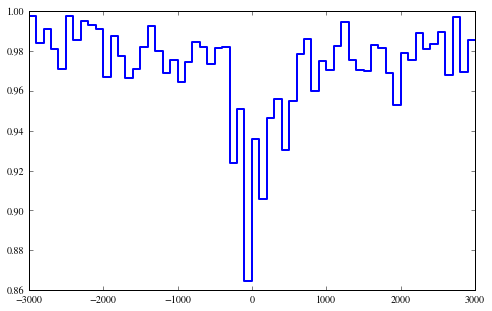

In [33]:
fin_flx_med = np.median(stck_img*stck_mskN,0)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo,fin_flx_med,drawstyle='steps',linewidth=2.)

In [34]:
tau = np.log(1./fin_flx)
print('tau weighted mean =',np.sum(fin_velo*tau)/np.sum(tau)) 
print('tau weighted RMS =',np.sqrt(np.sum((fin_velo**2)*tau)/np.sum(tau)))
print('tau weighted mean, within 2000 km/s=',np.sum(fin_velo[10:51]*tau[10:51])/np.sum(tau[10:51]))

tau weighted mean = -65.0225035684 km / s
tau weighted RMS = 1340.79278608 km / s
tau weighted mean, within 2000 km/s= 38.3641086313 km / s


# Plot individual spectra 

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq9_final.fits
length of sample after and before culling 32 56
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
St

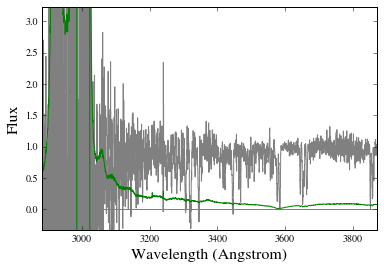

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xa

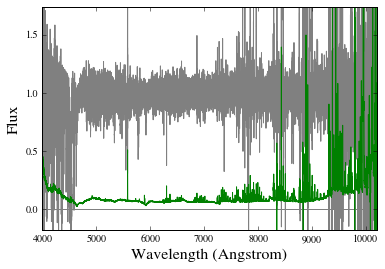

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

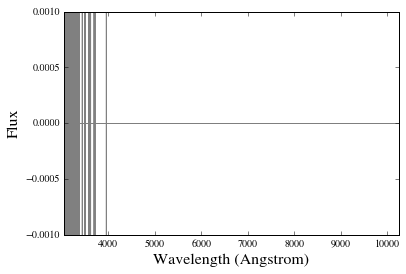

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

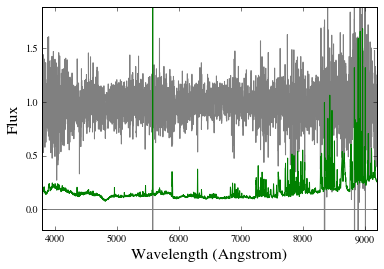

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

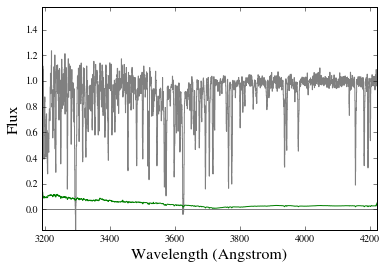

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xavi

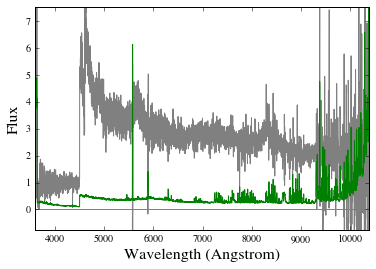

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

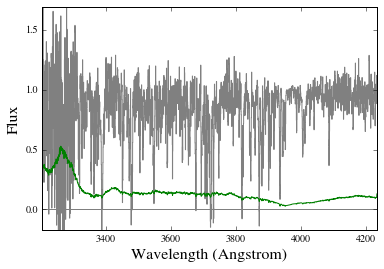

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

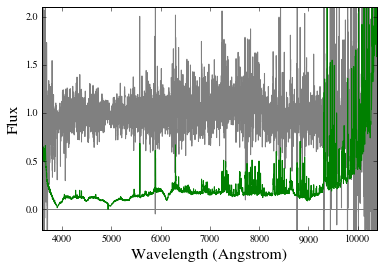

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

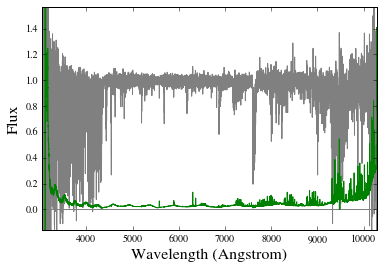

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
Using /u/xavier/Dropbox//QSOPa

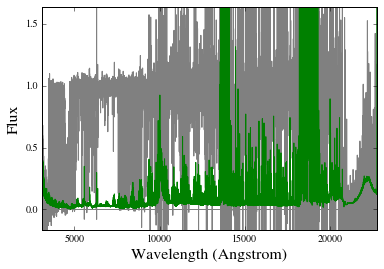

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

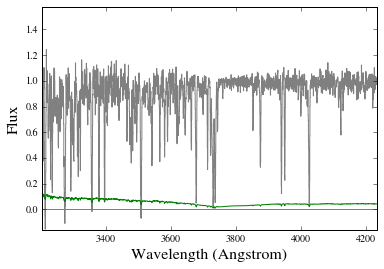

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

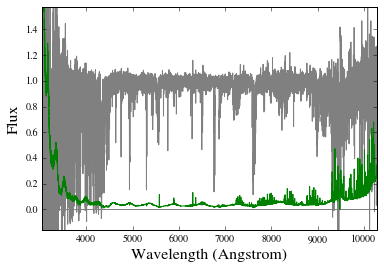

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

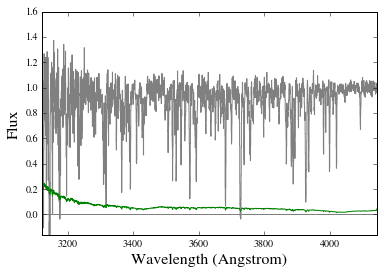

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in

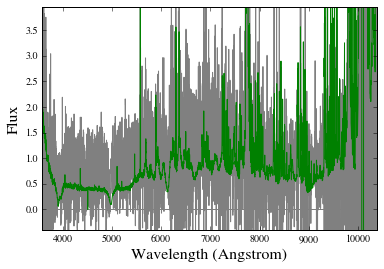

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

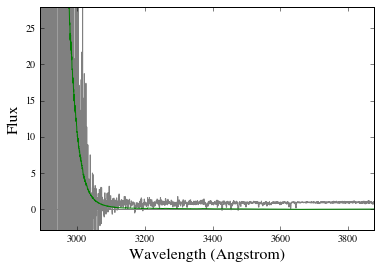

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

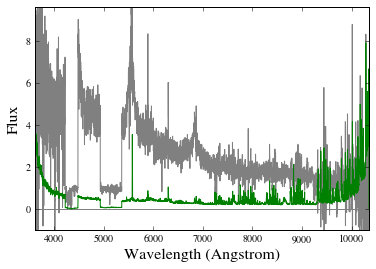

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

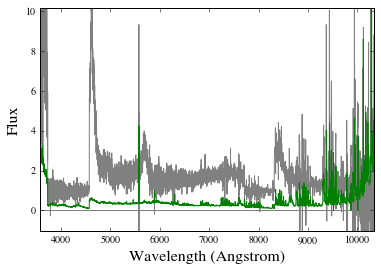

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHO

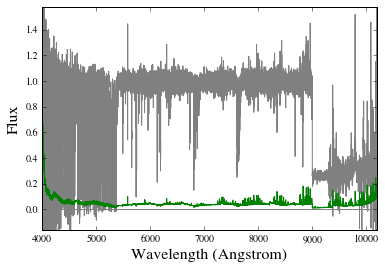

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/

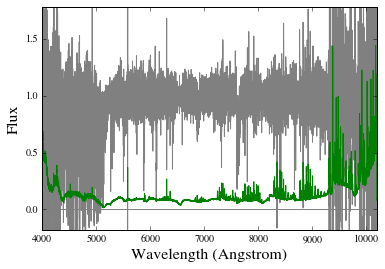

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 2 spectra totalling 0.000168 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 1 spectra totalling 0.0008 Gb
Loaded spectra
No continuum: 

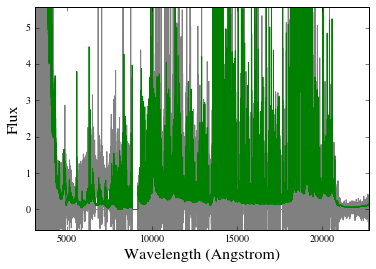

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/x

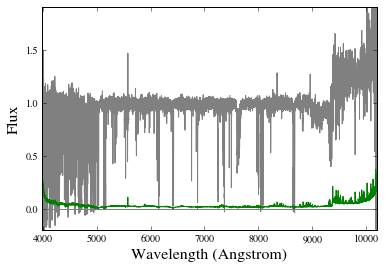

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

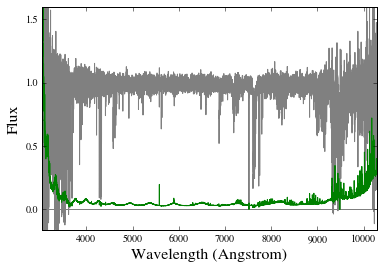

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 1 spectra totalling 0.00144 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continuu

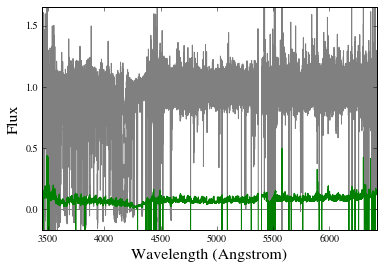

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

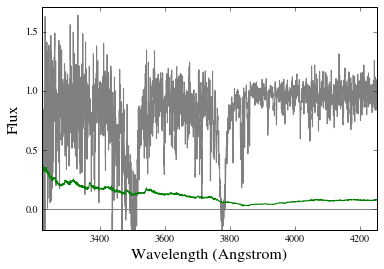

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

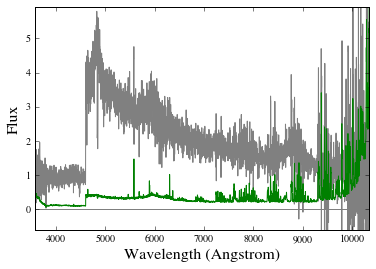

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

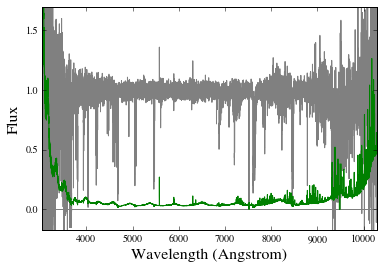

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continu

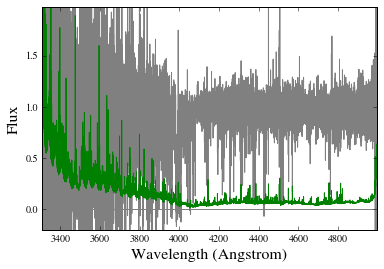

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 8 spectra totalling 0.0008 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

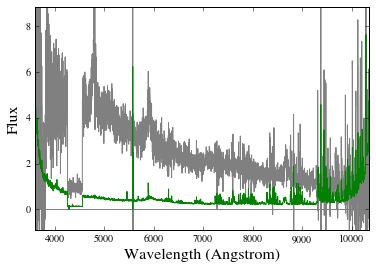

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

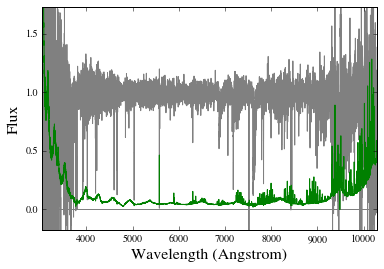

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

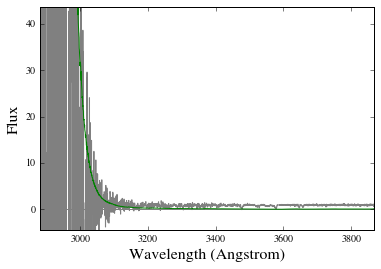

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 1 spectra totalling 0.0007 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

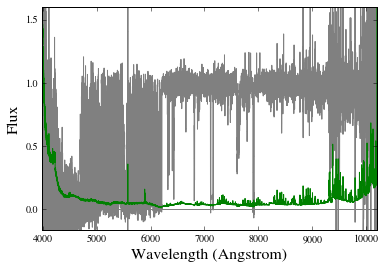

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 2 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

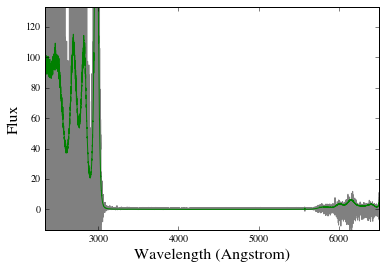

Wrote plt_qpq9_IRMgII_1334_page1.pdf
Wrote plt_qpq9_IRMgII_1334_page2.pdf
Wrote plt_qpq9_IRMgII_1334_page3.pdf


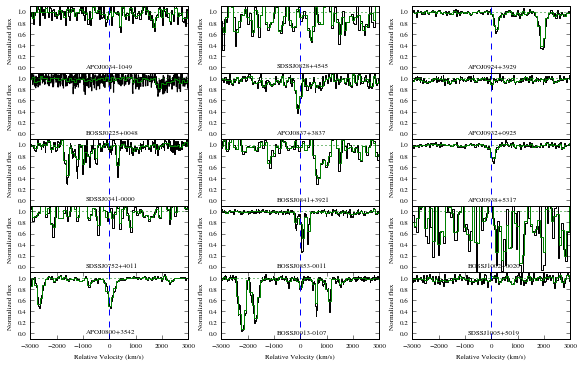

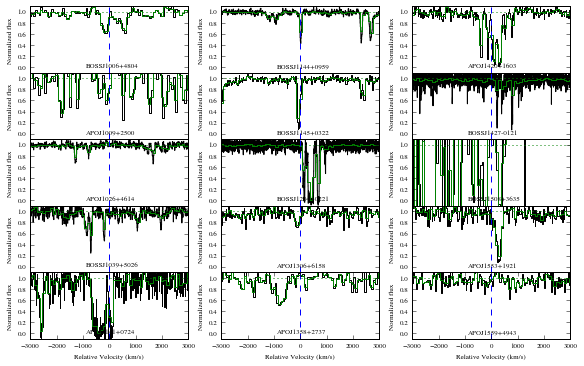

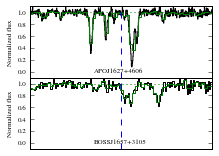

In [6]:
%matplotlib inline
import glob,os,sys,copy 
sys.path.append(os.path.abspath("./py"))
import qpq9_stacks as qpq9k
import astropy.units as u
qpq9k.plt_qpq9(wrest=1334.5323*u.AA)

# QPQ7 stack

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq7_pairs.fits.gz
length of sample after and before culling 72 427
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MOD

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:295: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


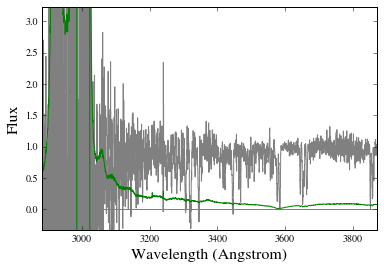

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:850: RuntimeWarning: invalid value encountered in true_divide
  return super(Quantity, self).__itruediv__(other)
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:269: RuntimeWarning: invalid value encountered in greater
  gdsigval = np.where(self.data['sig'][kk].data > 0.)[0]
/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:270: RuntimeWarning: invalid value encountered in less_equal
  badsigval = self.data['sig'][kk].data <= 0.


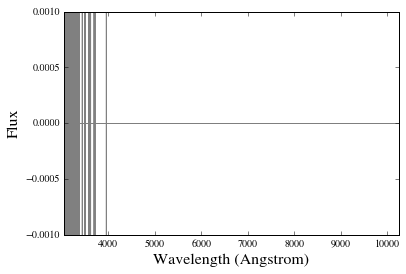

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

/Users/lwymarie/python/linetools/linetools/spectra/xspectrum1d.py:807: UserWarning: Ignoring NAN in flux
  warnings.warn("Ignoring NAN in flux")


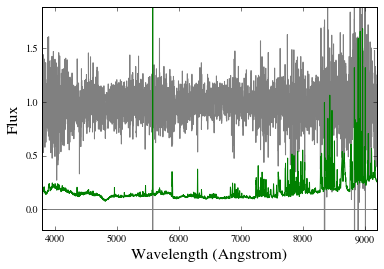

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

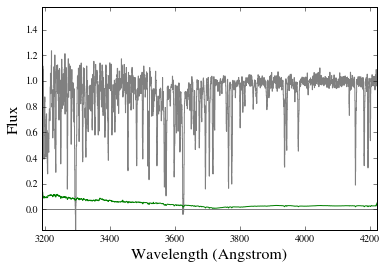

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xavi

/Users/lwymarie/python/specdb/specdb/specdb.py:88: UserWarning: Found multiple sources.  Hope you expected that.
  warnings.warn("Found multiple sources.  Hope you expected that.")


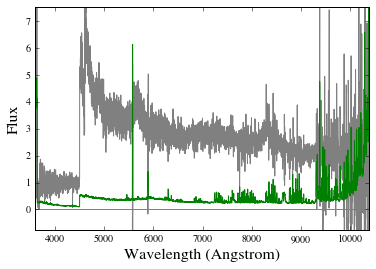

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

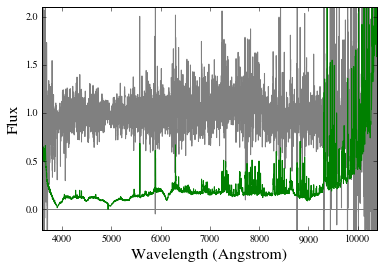

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

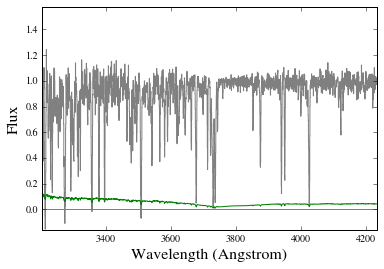

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

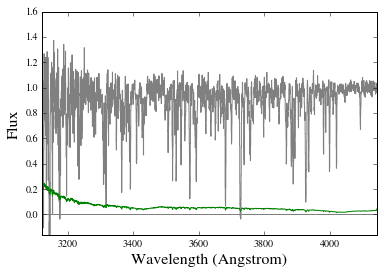

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

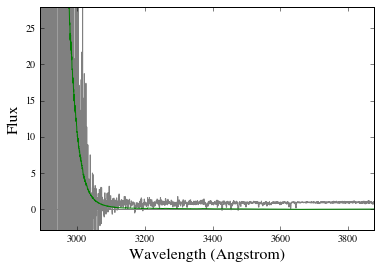

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

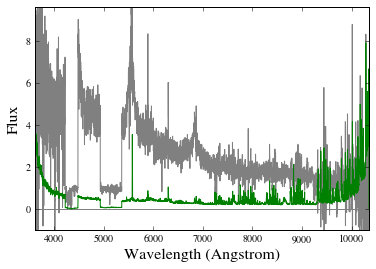

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

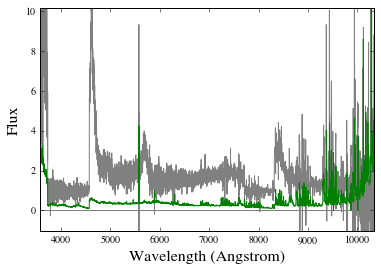

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

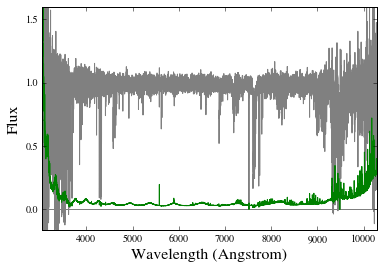

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

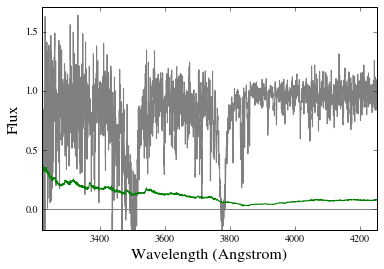

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

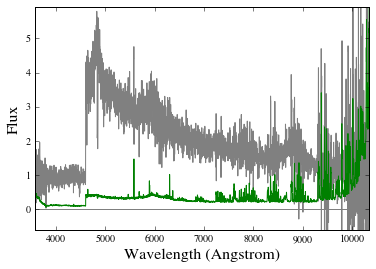

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continu

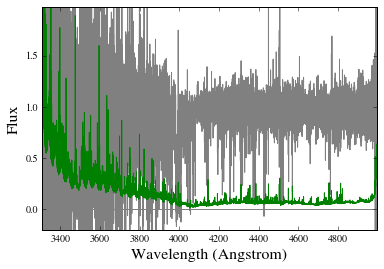

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 8 spectra totalling 0.0008 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

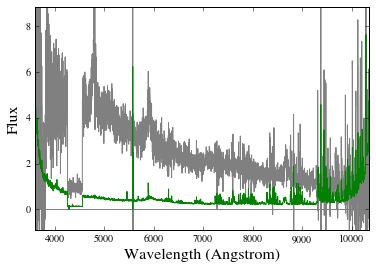

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

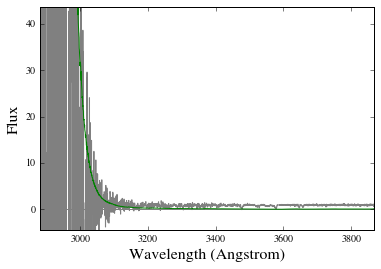

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 2 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

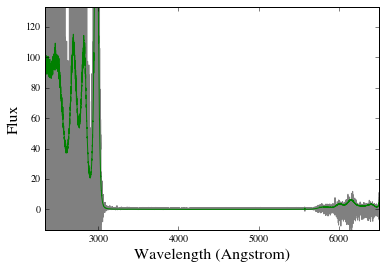

In [3]:
import qpq9_stacks_qpq7 as qpq9k7
stack_tup0 = qpq9k7.qpq7_MgII(passback=True,wrest=1334.5323*u.AA)

Reading /Users/lwymarie/python/enigma/enigma/data/qpq/qpq7_pairs.fits.gz
length of sample after and before culling 72 427
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MOD

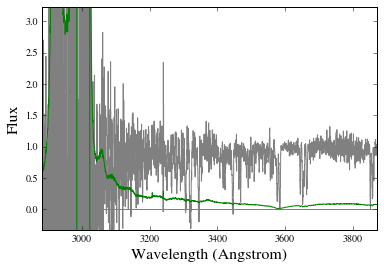

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

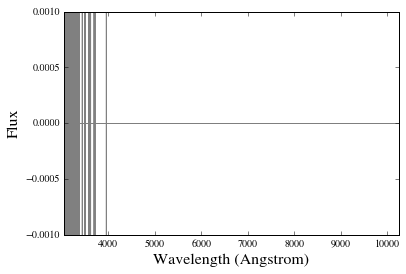

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

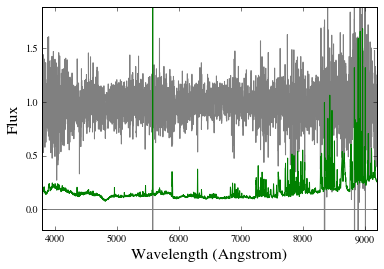

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

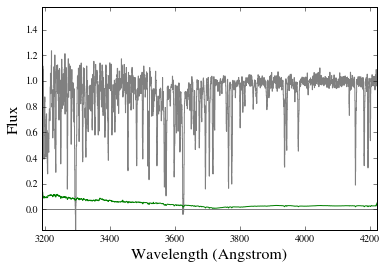

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
Using /u/xavi

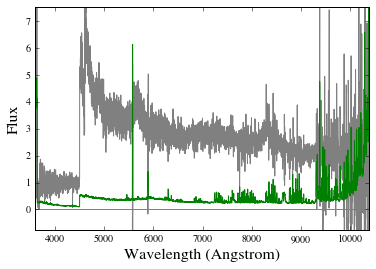

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 4 spectra totalling 0.0004 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

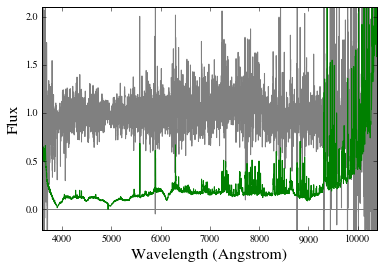

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

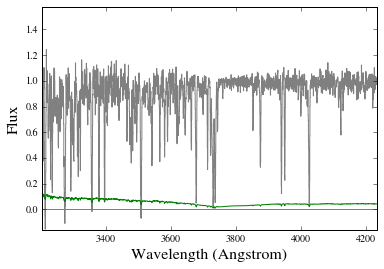

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

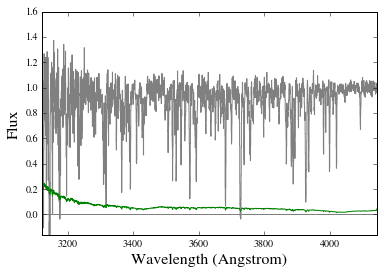

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 1 spectra totalling 8e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTE

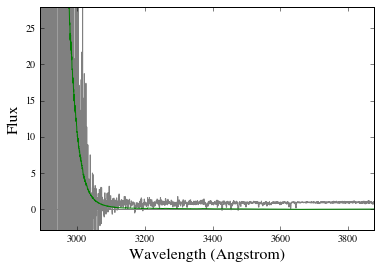

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

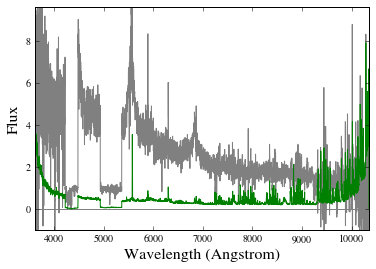

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

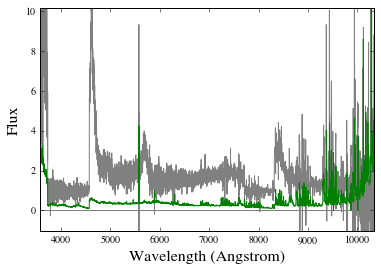

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOO

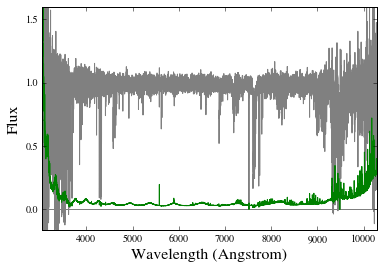

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

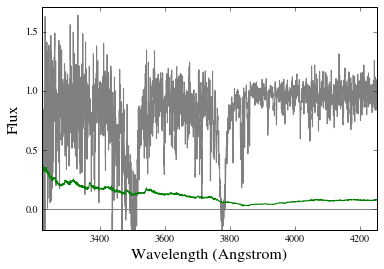

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 3 spectra totalling 0.0003 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

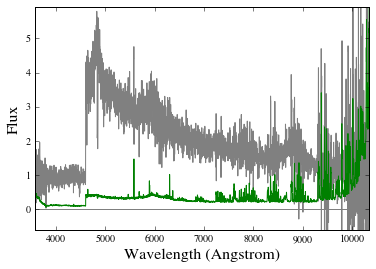

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 1 spectra totalling 0.00016 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 1 spectra totalling 0.00036 Gb
Loaded spectra
Staged 3 spectra totalling 0.00612 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOTER
No continu

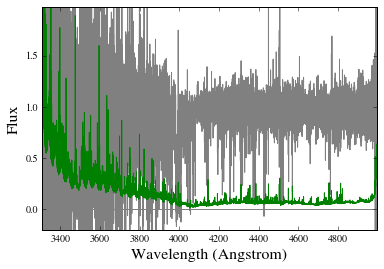

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 8 spectra totalling 0.0008 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey XSHOOT

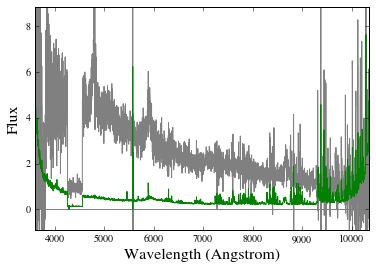

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 1 spectra totalling 8.4e-05 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MODS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

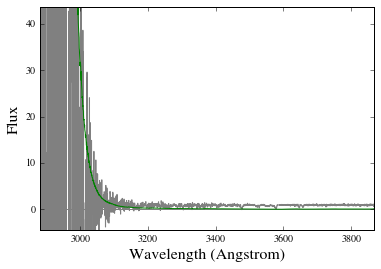

Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the catalog file
Using /Users/lwymarie/Desktop/qpq_optical.hdf5 for the DB file
Available surveys: [u'GMOS', u'MODS', u'HIRES', u'MMT', u'XSHOOTER', u'MIKE', u'BOSS', u'MAGE', u'LRIS', u'SDSS', u'ESI']
Database is QPQ
Created on 2016-Oct-11
Staged 0 spectra totalling 0 Gb
No spectra matching in survey BOSS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey ESI
Staged 0 spectra totalling 0 Gb
No spectra matching in survey GMOS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey HIRES
Staged 0 spectra totalling 0 Gb
No spectra matching in survey LRIS
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MAGE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MIKE
Staged 0 spectra totalling 0 Gb
No spectra matching in survey MMT
Staged 2 spectra totalling 0.00036 Gb
Loaded spectra
Staged 0 spectra totalling 0 Gb
No spectra matching in survey SDSS
Staged 0 spectra totalling 0 Gb
No spectra matching i

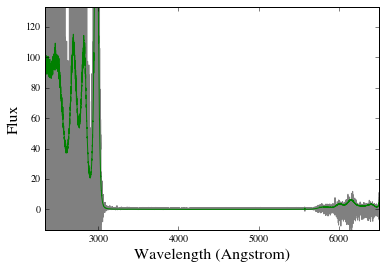

Wrote plt_qpq7_MgII_1334_page1.pdf
Wrote plt_qpq7_MgII_1334_page2.pdf


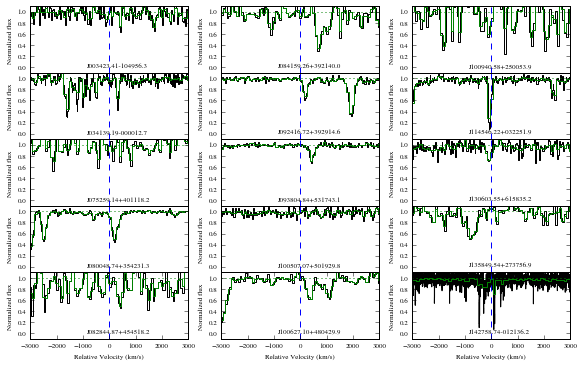

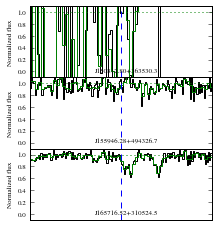

In [18]:
qpq9k7.plt_qpq7(wrest=1334.5323*u.AA)

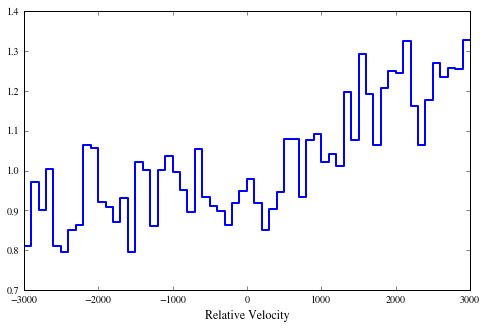

In [19]:
fin_velo, stck_img, stck_msk, all_dict = stack_tup0
stack_tup = (fin_velo, stck_img, stck_msk, all_dict)
#
fin_velo, fin_flx, all_dict = qpqk.stack_avg(stack_tup)
plt.figure(figsize=(8,5),dpi=1200)
plt.plot(fin_velo, fin_flx, drawstyle='steps',linewidth=2.)
plt.xlabel('Relative Velocity', size=12.)
plt.show()